In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
import math
from tqdm import tqdm
from keras.models import load_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('saved/scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [3]:
model = load_model("saved/model.h5")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 168, 16)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 168, 64)           20736     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 33,185
Trainable params: 33,185
Non-trainable params: 0
_________________________________________________________________


### Ground truth

In [4]:
test = pd.read_excel("dataset/raw/traffic_data_2013-23.xlsx")

In [5]:
test['Date'] = pd.to_datetime(test['Report Date'])
test['Hour'] = pd.to_timedelta(test['Time Period Ending'].str.slice(0, 2) + ':00:00')
test['Datetime'] = test['Date'] + test['Hour']

In [6]:
test.drop(['Site Name','Report Date','Time Period Ending','Avg mph','Date','Hour'], axis=1, inplace=True)

In [7]:
test = test.groupby('Datetime')['Total Volume'].sum().reset_index()

In [8]:
test = test.set_index('Datetime')
date_range = pd.date_range(start=test.index.min(), end=test.index.max(), freq='H')
test = test.reindex(date_range, fill_value=np.nan)
test.index.names = ['Datetime']

In [9]:
test = test[(test.index >= "2020-01-01 00:00:00") & (test.index < "2020-02-01 00:00:00")]

In [10]:
test

,Total Volume
Datetime,
2020-01-01 00:00:00,61.0
2020-01-01 01:00:00,62.0
2020-01-01 02:00:00,36.0
2020-01-01 03:00:00,22.0
2020-01-01 04:00:00,17.0
...,...
2020-01-31 19:00:00,381.0
2020-01-31 20:00:00,233.0
2020-01-31 21:00:00,189.0


<AxesSubplot:xlabel='Datetime'>

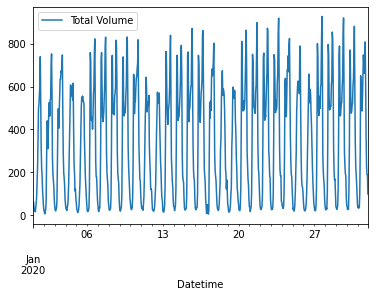

In [11]:
test.plot()

### Preparing testing set

#### weather

In [12]:
weather = pd.read_excel("dataset/raw/weather_data_2013-23.xlsx")
weather.shape

(86184, 8)

In [13]:
weather['time'] = pd.to_datetime(weather['time'])
weather.rename(columns={'time': 'Datetime'}, inplace=True)
weather = weather.set_index('Datetime')

In [14]:
weather = weather[(weather.index >= "2020-01-01 00:00:00") & (weather.index < "2020-02-01 00:00:00")]

In [15]:
weather.shape

(744, 7)

In [16]:
weather

,temperature_2m,relativehumidity_2m,precipitation,rain,snowfall,weathercode,windspeed_10m
Datetime,,,,,,,
2020-01-01 00:00:00,5.4,95,0.0,0.0,0.0,3,11.3
2020-01-01 01:00:00,5.0,95,0.0,0.0,0.0,3,9.5
2020-01-01 02:00:00,4.7,95,0.0,0.0,0.0,3,8.3
2020-01-01 03:00:00,4.5,95,0.0,0.0,0.0,3,7.2
2020-01-01 04:00:00,4.5,95,0.0,0.0,0.0,3,6.9
...,...,...,...,...,...,...,...
2020-01-31 19:00:00,10.6,94,0.0,0.0,0.0,3,26.5
2020-01-31 20:00:00,10.6,95,0.0,0.0,0.0,3,25.6
2020-01-31 21:00:00,10.6,96,0.0,0.0,0.0,3,24.4


#### sequences

In [17]:
train = pd.read_csv("dataset/processed/traffic-weather-data.csv")
train.shape

(57720, 17)

In [18]:
train['Datetime'] = pd.to_datetime(train['Datetime'])
train = train.set_index('Datetime')

In [19]:
take_n_dates_past = 7
forecast_n_dates_future = 2

n_past = 24*take_n_dates_past
n_future = 24*forecast_n_dates_future

In [20]:
chunk = train.iloc[len(train)-n_future+1-n_past:]

In [21]:
chunk.index.min(), chunk.index.max()

(Timestamp('2019-12-23 01:00:00'), Timestamp('2019-12-31 23:00:00'))

In [48]:
def AppendRow(array, date):
    
    new_row = []
    new_row.append(test.loc[date]['Total Volume'])
    new_row.extend([date.year, date.day, np.sin(2 * np.pi * date.month/12), np.cos(2 * np.pi * date.month/12)])
    new_row.extend([np.sin(2 * np.pi * date.dayofweek/7), np.cos(2 * np.pi * date.dayofweek/7), np.sin(2 * np.pi * date.hour/24), np.cos(2 * np.pi * date.hour/24)])
    new_row.extend(weather.loc[date].tolist())
    new_row = np.array(new_row).reshape(1, 16)
    new_row = scaler.transform(new_row)
    
    return np.concatenate((array, new_row), axis=0)

In [49]:
scaled_chunk = scaler.transform(chunk)
scaled_chunk.shape

(215, 16)

In [50]:
dates = pd.date_range(start=test.index.min(), end=test.index.max(), freq='H')

In [52]:
pred_volume_dict = {}

for i, date in tqdm(enumerate(dates), total=len(dates), desc="Processing"):
    input_array = scaled_chunk[i:i+n_past].reshape((1,168,16))
    pred_volume = model.predict(input_array)
    unscaled_volume = scaler.inverse_transform(np.pad(pred_volume, ((0, 0), (0, 15)), mode='constant'))[0][0]
    pred_volume_dict[date] = unscaled_volume
    scaled_chunk = AppendRow(scaled_chunk, date)

Processing: 100%|████████████████████████████████████████████████████████████████████| 744/744 [06:27<00:00,  1.92it/s]


In [53]:
pred = pd.DataFrame(list(pred_volume_dict.items()), columns=['Datetime', 'Pred Volume'])
pred.set_index('Datetime', inplace=True)
pred['Pred Volume'] = pred['Pred Volume'].apply(math.ceil)
pred['Pred Volume'] = pred['Pred Volume'].apply(lambda x: x if x>0 else 0)

In [54]:
pd.merge(test, pred, left_index=True, right_index=True)

,Total Volume,Pred Volume
Datetime,,
2020-01-01 00:00:00,61.0,43
2020-01-01 01:00:00,62.0,21
2020-01-01 02:00:00,36.0,4
2020-01-01 03:00:00,22.0,0
2020-01-01 04:00:00,17.0,10
...,...,...
2020-01-31 19:00:00,381.0,366
2020-01-31 20:00:00,233.0,248
2020-01-31 21:00:00,189.0,176


In [55]:
mse = mean_squared_error(test['Total Volume'], pred['Pred Volume'])
mse

3682.8118279569894

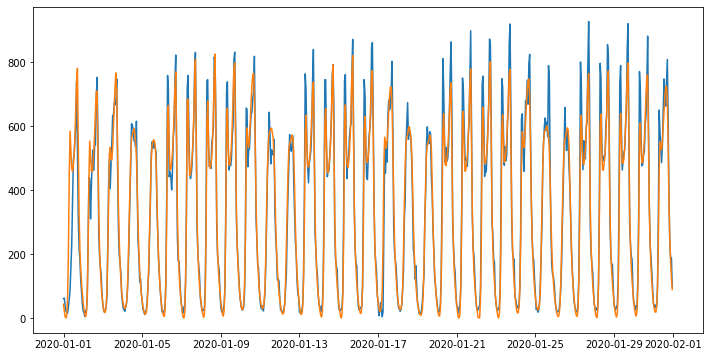

In [56]:
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(pred)